# Bayesian Linear Regression: Warmup

We will implement the expression for the posterior distribution $p(\boldsymbol{\theta}| \mathcal{D}, \sigma_{\epsilon}^2, I)$ for the parameters $\boldsymbol{\theta}$ of a linear model with data $\mathcal{D}$. 

The posterior is can be obtained from Bayes' theorem:

$$
p\left(\boldsymbol{\theta}| \mathcal{D}, \sigma_{\epsilon}^2, I\right) \propto p\left(\mathcal{D}|\boldsymbol{\theta}, \sigma_{\epsilon}^2, I\right)
p\left(\boldsymbol{\theta}| \sigma_{\epsilon}^2, I\right)
$$

where the likelihood $p\left(\mathcal{D}|\boldsymbol{\theta}, \sigma_{\epsilon}^2, I\right)$ can be expressed in terms of the residual errors (under the assumption of identical and identically distributed errors):

$$
p\left(\mathcal{D}|\boldsymbol{\theta}, \sigma_{\epsilon}^2, I\right) = \left( \frac{1}{2\pi\sigma_\epsilon^2} \right)^{N_d/2} \mathrm{exp}  \left[-\frac{1}{2} \frac{\left( \mathcal{D} - \boldsymbol{X}\boldsymbol{\theta}  \right)^T \left( \mathcal{D} - \boldsymbol{X}\boldsymbol{\theta}  \right)}{\sigma_\epsilon^2}  \right].
$$

This expression can be rewritten (Exercise 18.1) in terms of the ordinary linear regression solution $\boldsymbol{\theta}^* = \left(\boldsymbol{X}^T\boldsymbol{X} \right)^{-1}\boldsymbol{X}^T \mathcal{D}$,

$$
p\left(\mathcal{D}|\boldsymbol{\theta}, \sigma_{\epsilon}^2, I\right) \propto \mathrm{exp}  \left[-\frac{1}{2} \left(\boldsymbol{\theta} - \boldsymbol{\theta}^* \right)^T \Sigma_\theta^{-1}\left(\boldsymbol{\theta} - \boldsymbol{\theta}^* \right) \right]
$$

where 

$$
\Sigma_\theta^{-1} = \frac{X^TX}{\sigma_\epsilon^2}.
$$

Under a Gaussian prior, 

$$
p\left(\boldsymbol{\theta}| \sigma_{\epsilon}^2, I\right) \propto  \mathrm{exp}  \left[-\frac{1}{2} \frac{\boldsymbol{\theta}^T \boldsymbol{\theta}}{\sigma_\theta^2} \right],
$$

the posterior can finally be rewritten as 

$$
p\left(\boldsymbol{\theta}| \mathcal{D}, \sigma_{\epsilon}^2, I\right) \propto 
\mathrm{exp}  
\left[-\frac{1}{2} 
\left(\boldsymbol{\theta} - \tilde{\boldsymbol{\theta}} \right)^T
\tilde{\Sigma}_\theta^{-1}
\left(\boldsymbol{\theta} - \tilde{\boldsymbol{\theta}}\right)
\right],
$$

with 

$$
\tilde{\boldsymbol{\theta}} = \tilde{\Sigma}_\theta \Sigma_\theta^{-1} \boldsymbol{\theta}^*
$$

and

$$
\tilde{\Sigma}_\theta^{-1} = \Sigma_\theta^{-1} + \sigma_\theta^{-2}\boldsymbol{1}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Ordinary linear regression

We are in the same situation as in chapter 8.3. Ordinary linear regression: warmup. We thus have two datapoints and corresponding predictor values, $\mathcal{D} = [y_0,y_1]^T = [-3, 3]^T$ and $[x_0, x_1]^T = [-2, 1]$. We assume a linear model with two parameters, $M(\boldsymbol{\theta}, x) = \theta_0 + \theta_1 x$.

We will borrow the functions we implemented during the first demo for constructing the design matrix $X$ and solving the normal equation for $\theta^*$.

In [2]:
def setup_polynomial_design_matrix(data, poldeg):
    # numpy.vander is only one way of generating the design matrix
    data = np.array(data).reshape(-1)
    design_matrix = np.vander(data, poldeg+1, increasing = True)
    return design_matrix


def solve_normal_equation(X, D):
    XTX = X.T @ X
    print(XTX)
    XTXinv = np.linalg.inv(XTX)
    XTD = X.T @ D
    theta_star = XTXinv @ XTD
    return theta_star.flatten()


y = np.array([-3, 3])
x = np.array([-2, 1])

poldeg = 1
X = setup_polynomial_design_matrix(x, poldeg)
print(X)
theta_star = solve_normal_equation(X, y)
print('OLS solution: theta_star=', theta_star)

[[ 1 -2]
 [ 1  1]]
[[ 2 -1]
 [-1  5]]
OLS solution: theta_star= [1. 2.]


## Step 2: Functions for the likelihood covariance

We need a function to evaluate the likelihood covariance,


$$
\Sigma_\theta^{-1} = \frac{X^TX}{\sigma_\epsilon^2},
$$

expressed in terms of the design matrix $X$. We are given that the residual variance is $\sigma_\epsilon^2 = 0.5^2$

In [3]:
def sigma_inv(X, sigma_epsilon_sq):
    return (X.T @ X) / sigma_epsilon_sq

sigma_epsilon_sq = 0.5**2

siginv = sigma_inv(X, sigma_epsilon_sq)
print(siginv)

[[ 8. -4.]
 [-4. 20.]]


## Step 3: Functions for the posterior mean and covariance

We now implement functions for the posterior mean, 

$$
\tilde{\boldsymbol{\theta}} = \tilde{\Sigma}_\theta \Sigma_\theta^{-1} \boldsymbol{\theta}^*
$$

and covariance,

$$
\tilde{\Sigma}_\theta^{-1} = \Sigma_\theta^{-1} + \sigma_\theta^{-2}\boldsymbol{1}
$$

expressed in terms of the design matrix $X$ and the OLS solution $\theta^*$.

We are also given that the prior variance is $\sigma_\theta=5.0^2$.

In [4]:
def sigma_tilde_inv(X, sigma_epsilon_sq, sigma_theta_sq):
    return sigma_inv(X, sigma_epsilon_sq) + 1/sigma_theta_sq*np.eye(X.shape[0])


def theta_tilde(theta_star, X, sigma_epsilon_sq, sigma_theta_sq):
    siginv = sigma_inv(X, sigma_epsilon_sq)
    
    sigtildeinv = sigma_tilde_inv(X, sigma_epsilon_sq, sigma_theta_sq)
    sigtilde = np.linalg.inv(sigtildeinv)
    
    return sigtilde @ siginv @ theta_star


sigma_theta_sq = 5.0**2

thetatilde = theta_tilde(theta_star, X, sigma_epsilon_sq, sigma_theta_sq)
sigtildeinv = sigma_tilde_inv(X, sigma_epsilon_sq, sigma_theta_sq)

print("Bayesian posterior mean= ", thetatilde)
print("Bayesian posterior covariance= ", np.linalg.inv(sigtildeinv))

Bayesian posterior mean=  [0.99227131 1.99446533]
Bayesian posterior covariance=  [[0.13809109 0.02756309]
 [0.02756309 0.05540181]]


# Step 4: Plotting the posterior distribution

(1000, 1000, 2)
(1000, 1000)


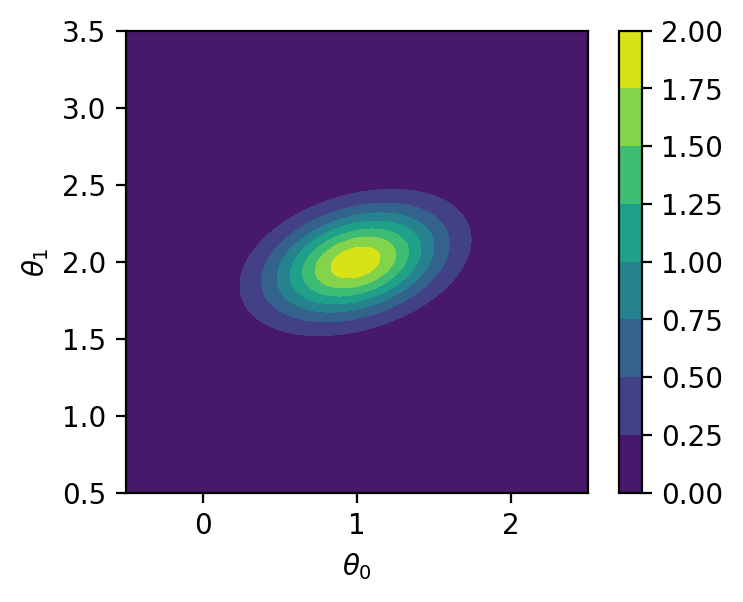

In [5]:
from scipy.stats import multivariate_normal

mu = thetatilde
Sigma = np.linalg.inv(sigtildeinv)

posterior = multivariate_normal(mean=mu, cov=Sigma)

theta0, theta1 = np.linspace(-0.5, 2.5, 1000), np.linspace(0.5, 3.5, 1000)
T1, T2 = np.meshgrid(theta0, theta1)

theta_grid = np.dstack((T1, T2))
print(theta_grid.shape)
post = posterior.pdf(theta_grid)
print(T2.shape)


fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
im = ax.contourf(T1, T2, post)
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_aspect('equal')
fig.colorbar(im)

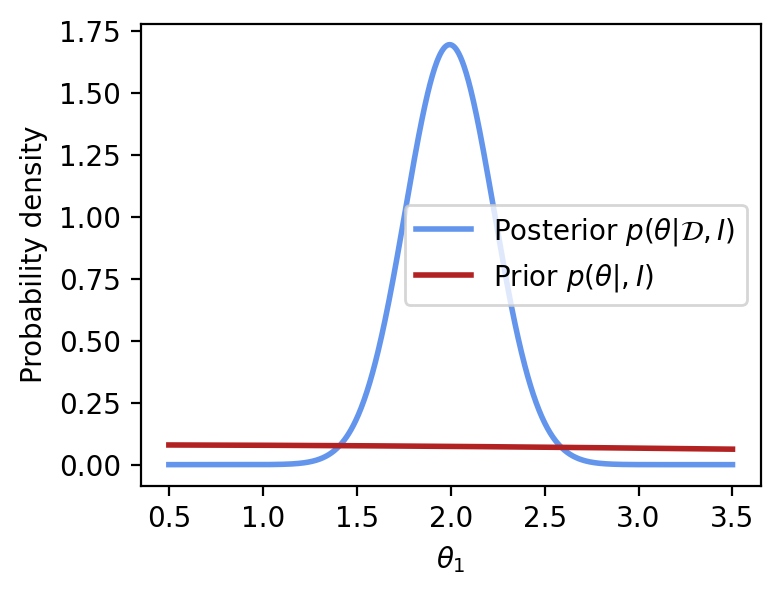

In [6]:
# We can also plot the marginal distribution for \theta_1 using equation 18.20
mu1 = mu[1]
Sigma11_sq = Sigma[1,1]

posterior1 = multivariate_normal(mu1, Sigma11_sq)
prior = multivariate_normal(0, sigma_theta_sq)

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
ax.plot(theta1, posterior1.pdf(theta1), c='cornflowerblue', lw=2, label=r'Posterior $p(\theta|\mathcal{D},I)$')
ax.plot(theta1, prior.pdf(theta1), c='firebrick', lw=2, label=r'Prior $p(\theta|,I)$')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel('Probability density')
ax.legend(loc='best', frameon=True)

# Step 5: Varying $\sigma_\epsilon$ and $\sigma_\theta$

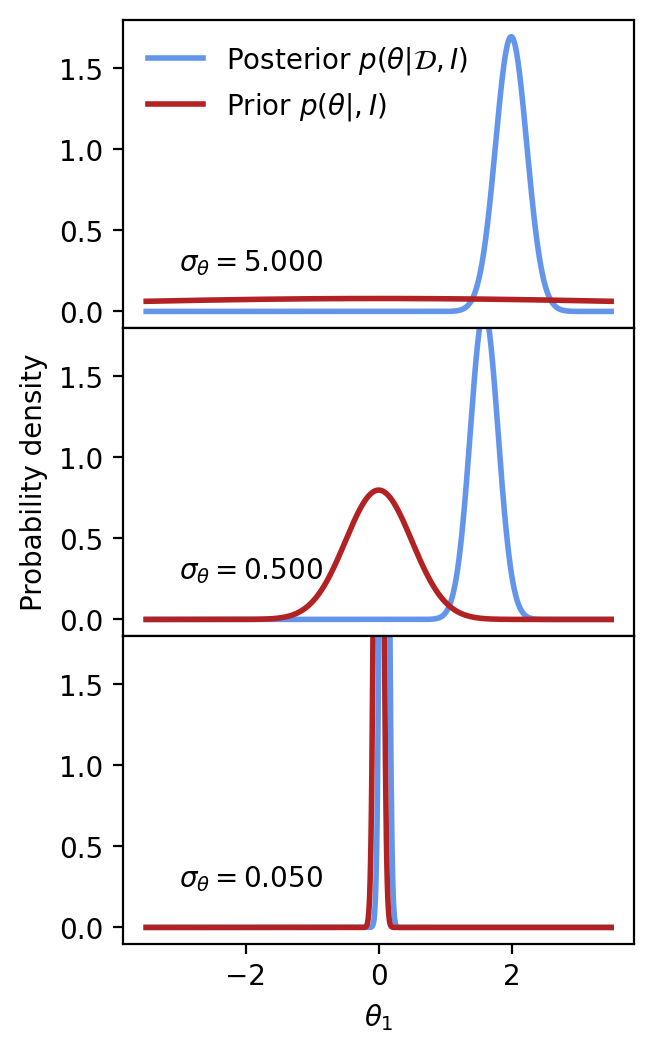

In [7]:
sigma_thetas = [5.0, 0.5, 0.05]
# Original values
sigma_epsilon = 0.5
sigma_theta = 5.0


def solve(sigma_theta_sq, sigma_epsilon_sq):
    mu = theta_tilde(theta_star, X, sigma_epsilon_sq, sigma_theta_sq)
    sigtildeinv = sigma_tilde_inv(X, sigma_epsilon_sq, sigma_theta_sq)
    cov = np.linalg.inv(sigtildeinv)
    return mu, cov


def plot_posterior_and_prior(mu, cov, sigma_theta_sq, ax):
    theta0, theta1 = np.linspace(-2.5, 2.5, 1000), np.linspace(-3.5, 3.5, 1000)
    mu1 = mu[1]
    Sigma11_sq = cov[1,1]

    posterior1 = multivariate_normal(mu1, Sigma11_sq)
    prior = multivariate_normal(0, sigma_theta_sq)

    ax.plot(theta1, posterior1.pdf(theta1), c='cornflowerblue', lw=2, label=r'Posterior $p(\theta|\mathcal{D},I)$')
    ax.plot(theta1, prior.pdf(theta1), c='firebrick', lw=2, label=r'Prior $p(\theta|,I)$')
    

    
fig, axs = plt.subplots(nrows=3, figsize=(3.3, 6), dpi=200, sharex=True)

for ax, st in zip(axs, sigma_thetas):
    mu, cov = solve(st**2, sigma_epsilon**2)
    plot_posterior_and_prior(mu, cov, st**2, ax)
    ax.text(-3, 0.25, r'$\sigma_\theta=$' + f'{st:.3f}')
    ax.set_ylim([-0.1, 1.8])

ax = axs[0]
ax.legend(loc='best', frameon=False)
ax = axs[1]
ax.set_ylabel('Probability density')
ax = axs[2]
ax.set_xlabel(r'$\theta_1$')
    
plt.subplots_adjust(wspace=0, hspace=0)


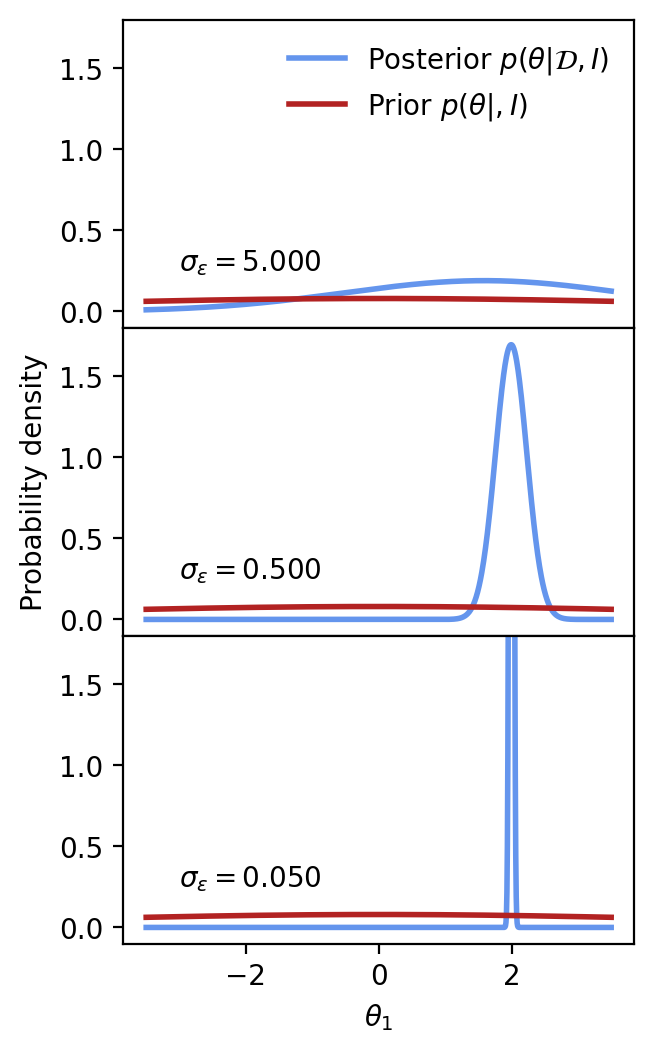

In [8]:
sigma_epsilon = [0.5, 0.05, 5.0]

fig, axs = plt.subplots(nrows=3, figsize=(3.3, 6), dpi=200, sharex=True)

for ax, se in zip(axs, sigma_thetas):
    mu, cov = solve(sigma_theta**2, se**2)
    plot_posterior_and_prior(mu, cov, sigma_theta**2, ax)
    ax.text(-3, 0.25, r'$\sigma_\epsilon=$' + f'{se:.3f}')
    ax.set_ylim([-0.1, 1.8])

ax = axs[0]
ax.legend(loc='best', frameon=False)
ax = axs[1]
ax.set_ylabel('Probability density')
ax = axs[2]
ax.set_xlabel(r'$\theta_1$')
    
plt.subplots_adjust(wspace=0, hspace=0)